# Optimización Adaptativa de Redes WiFi mediante Reinforcement Learning

**Autores:** Jarod Tierra y Andrés Vega  
**NRC:** 3710  
**Proyecto:** Optimización de redes WiFi con Deep Q-Network (DQN)

---

## Tabla de Contenidos

1. [Setup e Instalación](#setup)
2. [Implementación del Entorno WiFi](#entorno)
3. [Implementación del Agente DQN](#agente)
4. [Función de Recompensa Multi-Objetivo](#recompensa)
5. [Entrenamiento del Modelo](#entrenamiento)
6. [Evaluación y Comparación con Baselines](#evaluacion)
7. [Análisis de Resultados](#analisis)
8. [Simulación de estrés](#simulación)

---
## 1. Setup e Instalación <a name="setup"></a>

### Instalación de Dependencias

In [1]:
# Instalación de paquetes necesarios
!pip install tensorflow numpy matplotlib seaborn pandas scikit-learn pyyaml tqdm

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
# Imports principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque, defaultdict
import random
from typing import Dict, List, Tuple, Any
import yaml
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponible: []


---
## 2. Implementación del Entorno WiFi <a name="entorno"></a>

### 2.1 Simulador WiFi Simplificado

Como NS-3 requiere instalación compleja, implementaremos un simulador simplificado pero realista que modela:
- Interferencia entre canales
- Propagación de señal (path loss)
- Throughput basado en RSSI y interferencia
- Latencia variable según congestión
- Pérdida de paquetes

In [3]:
class AccessPoint:
    """Representa un Access Point WiFi"""
    def __init__(self, ap_id: int, position: Tuple[float, float], 
                 initial_channel: int = 1, initial_power: float = 20.0):
        self.id = ap_id
        self.position = position  # (x, y) en metros
        self.channel = initial_channel
        self.tx_power = initial_power  # dBm
        self.connected_users = []
        self.throughput = 0.0
        self.latency = 0.0
        self.packet_loss = 0.0
        
    def __repr__(self):
        return f"AP{self.id}(ch={self.channel}, pwr={self.tx_power}dBm, users={len(self.connected_users)})"


class User:
    """Representa un usuario/estación WiFi"""
    def __init__(self, user_id: int, position: Tuple[float, float], 
                 traffic_demand: float = 5.0):
        self.id = user_id
        self.position = position
        self.traffic_demand = traffic_demand  # Mbps
        self.connected_ap = None
        self.rssi = -100.0
        self.throughput = 0.0
        
    def __repr__(self):
        return f"User{self.id}(AP={self.connected_ap}, RSSI={self.rssi:.1f}dBm)"

In [4]:
class WiFiSimulator:
    """Simulador WiFi DINÁMICO: El tráfico y la interferencia cambian con el tiempo"""
    
    CHANNELS_2_4GHZ = [1, 6, 11]
    
    # Matriz de interferencia (igual que antes)
    CHANNEL_INTERFERENCE = {
        (1, 1): 1.0, (1, 6): 0.3, (1, 11): 0.0,
        (6, 1): 0.3, (6, 6): 1.0, (6, 11): 0.3,
        (11, 1): 0.0, (11, 6): 0.3, (11, 11): 1.0,
    }
    
    def __init__(self, area_size: Tuple[float, float] = (100, 100)):
        self.area_size = area_size
        self.access_points: List[AccessPoint] = []
        self.users: List[User] = []
        self.time_step = 0
        
        # Factor de ruido externo dinámico (simula microondas, bluetooth, etc.)
        self.external_noise_factor = 0.0 
        
    def add_access_point(self, position: Tuple[float, float], 
                        channel: int = 1, power: float = 20.0) -> AccessPoint:
        ap = AccessPoint(len(self.access_points), position, channel, power)
        self.access_points.append(ap)
        return ap
    
    def add_user(self, position: Tuple[float, float], 
                traffic_demand: float = 5.0) -> User:
        user = User(len(self.users), position, traffic_demand)
        self.users.append(user)
        return user
    
    # ... (Mantener calculate_path_loss, calculate_rssi igual que antes) ...
    def calculate_path_loss(self, distance: float, frequency_ghz: float = 2.4) -> float:
        if distance < 1.0: distance = 1.0
        pl_d0 = 20 * np.log10(frequency_ghz * 1000) - 28
        path_loss_exponent = 3.5
        return pl_d0 + 10 * path_loss_exponent * np.log10(distance)

    def calculate_rssi(self, ap: AccessPoint, user: User) -> float:
        distance = np.sqrt((ap.position[0] - user.position[0])**2 + 
                          (ap.position[1] - user.position[1])**2)
        path_loss = self.calculate_path_loss(distance)
        rssi = ap.tx_power - path_loss
        noise = np.random.normal(0, 2.0)
        return rssi + noise

    def calculate_interference(self, ap: AccessPoint) -> float:
        """Calcula interferencia en el AP + RUIDO EXTERNO DINÁMICO"""
        interference = 0.0
        for other_ap in self.access_points:
            if other_ap.id == ap.id: continue
            
            channel_pair = (ap.channel, other_ap.channel)
            interference_factor = self.CHANNEL_INTERFERENCE.get(channel_pair, 0.1)
            
            distance = np.sqrt((ap.position[0] - other_ap.position[0])**2 + 
                             (ap.position[1] - other_ap.position[1])**2)
            
            if distance > 0:
                interference += interference_factor * (50.0 / distance)
        
        # Añadir ruido externo variable
        # Esto fuerza al agente a adaptarse si el ruido sube mucho
        total_interference = interference + self.external_noise_factor
        return min(total_interference, 10.0)
    
    # ... (Mantener calculate_throughput, latency, packet_loss igual que antes) ...
    def calculate_throughput(self, rssi: float, interference: float, num_users: int) -> float:
        if rssi > -50: max_rate = 150.0
        elif rssi > -60: max_rate = 100.0
        elif rssi > -70: max_rate = 50.0
        elif rssi > -80: max_rate = 20.0
        else: max_rate = 5.0
        
        rate_with_interference = max_rate * (1.0 - interference / 20.0)
        if num_users > 0: throughput_per_user = rate_with_interference / num_users
        else: throughput_per_user = 0.0
        return max(throughput_per_user, 0.0)

    def calculate_latency(self, rssi: float, num_users: int) -> float:
        if rssi > -60: base_latency = 5.0
        elif rssi > -70: base_latency = 15.0
        elif rssi > -80: base_latency = 40.0
        else: base_latency = 100.0
        
        congestion_factor = 1.0 + (num_users - 1) * 0.2
        latency = base_latency * congestion_factor
        jitter = np.random.exponential(5.0)
        return latency + jitter

    def calculate_packet_loss(self, rssi: float, interference: float) -> float:
        if rssi > -70: base_loss = 0.001
        elif rssi > -80: base_loss = 0.01
        else: base_loss = 0.05
        loss_with_interference = base_loss * (1.0 + interference / 10.0)
        return min(loss_with_interference, 0.5)

    def associate_users(self):
        for ap in self.access_points: ap.connected_users = []
        for user in self.users:
            best_ap = None
            best_rssi = -100.0
            for ap in self.access_points:
                rssi = self.calculate_rssi(ap, user)
                if rssi > best_rssi:
                    best_rssi = rssi
                    best_ap = ap
            if best_ap:
                user.connected_ap = best_ap.id
                user.rssi = best_rssi
                best_ap.connected_users.append(user)

    def update_metrics(self):
        for ap in self.access_points:
            interference = self.calculate_interference(ap)
            num_users = len(ap.connected_users)
            if num_users > 0:
                total_throughput = 0.0
                total_latency = 0.0
                total_packet_loss = 0.0
                for user in ap.connected_users:
                    # Usar la demanda de tráfico dinámica del usuario
                    capacity = self.calculate_throughput(user.rssi, interference, num_users)
                    # El throughput real está limitado por la demanda del usuario
                    thr = min(capacity, user.traffic_demand * 2.0) 
                    
                    lat = self.calculate_latency(user.rssi, num_users)
                    loss = self.calculate_packet_loss(user.rssi, interference)
                    
                    user.throughput = thr
                    total_throughput += thr
                    total_latency += lat
                    total_packet_loss += loss
                
                ap.throughput = total_throughput
                ap.latency = total_latency / num_users
                ap.packet_loss = total_packet_loss / num_users
            else:
                ap.throughput = 0.0
                ap.latency = 0.0
                ap.packet_loss = 0.0
    
    def step(self):
        """Ejecuta un paso con DINAMISMO"""
        # SOLUCIÓN 2: Tráfico de usuarios dinámico (Random Walk)
        for user in self.users:
            change = np.random.uniform(0.9, 1.1) # Variación del +/- 10%
            user.traffic_demand = np.clip(user.traffic_demand * change, 1.0, 20.0)
            
        # SOLUCIÓN 2: Ruido externo variable (Simular interferencia esporádica)
        # 10% de probabilidad de cambio brusco de ruido
        if np.random.random() < 0.1:
            self.external_noise_factor = np.random.uniform(0.0, 5.0)
            
        self.associate_users()
        self.update_metrics()
        self.time_step += 1
        
    # ... (Mantener get_state y reset igual) ...
    def get_state(self) -> np.ndarray:
        state = []
        for ap in self.access_points:
            state.extend([
                ap.tx_power / 20.0,
                ap.channel / 11.0,
                ap.throughput / 100.0,
                ap.latency / 100.0,
                ap.packet_loss,
                len(ap.connected_users) / 20.0,
                np.mean([u.rssi for u in ap.connected_users]) / (-100.0) if ap.connected_users else 0.0
            ])
        return np.array(state, dtype=np.float32)
    
    def reset(self):
        self.time_step = 0
        self.external_noise_factor = 0.0
        for ap in self.access_points:
            ap.channel = np.random.choice(self.CHANNELS_2_4GHZ)
            ap.tx_power = 20.0
            ap.connected_users = []
        self.step()
        return self.get_state()

### 2.2 Entorno Gym-Compatible

In [5]:
class WiFiEnvironment:
    """Entorno WiFi compatible con interfaz Gym"""
    
    def __init__(self, scenario_config: Dict):
        self.config = scenario_config
        self.simulator = WiFiSimulator(area_size=scenario_config['area_size'])
        
        # Crear APs en posiciones distribuidas
        num_aps = scenario_config['num_aps']
        area_x, area_y = scenario_config['area_size']
        
        # Distribución en grid
        grid_size = int(np.ceil(np.sqrt(num_aps)))
        for i in range(num_aps):
            x = (i % grid_size + 0.5) * (area_x / grid_size)
            y = (i // grid_size + 0.5) * (area_y / grid_size)
            self.simulator.add_access_point((x, y))
        
        # Crear usuarios en posiciones aleatorias
        num_users = scenario_config['num_users']
        for i in range(num_users):
            x = np.random.uniform(0, area_x)
            y = np.random.uniform(0, area_y)
            traffic = np.random.uniform(1.0, 10.0)
            self.simulator.add_user((x, y), traffic)
        
        # Dimensiones del espacio
        self.state_dim = 7 * num_aps
        self.num_aps = num_aps
        
        # Acciones: (ap_id, action_type, parameter)
        # action_type: 0=cambiar canal, 1=ajustar potencia
        self.channels = [1, 6, 11]
        self.power_adjustments = [-5, 0, 5]
        
        # Total de acciones por AP
        self.actions_per_ap = len(self.channels) + len(self.power_adjustments)
        self.action_dim = num_aps * self.actions_per_ap
        
        # Función de recompensa
        self.reward_function = None
        self.action_history = deque(maxlen=50)
        
        # Límites
        self.max_steps = 300
        self.current_step = 0
    
    def set_reward_function(self, reward_fn):
        """Establece la función de recompensa"""
        self.reward_function = reward_fn
    
    def decode_action(self, action_idx: int) -> Tuple[int, str, Any]:
        """Decodifica índice de acción a (ap_id, tipo, parámetro)"""
        ap_id = action_idx // self.actions_per_ap
        action_type_idx = action_idx % self.actions_per_ap
        
        if action_type_idx < len(self.channels):
            # Cambiar canal
            return ap_id, 'CHANGE_CHANNEL', self.channels[action_type_idx]
        else:
            # Ajustar potencia
            power_idx = action_type_idx - len(self.channels)
            return ap_id, 'ADJUST_POWER', self.power_adjustments[power_idx]
    
    def apply_action(self, action_idx: int):
        """Aplica acción al entorno"""
        ap_id, action_type, parameter = self.decode_action(action_idx)
        
        if ap_id < len(self.simulator.access_points):
            ap = self.simulator.access_points[ap_id]
            
            if action_type == 'CHANGE_CHANNEL':
                ap.channel = parameter
            elif action_type == 'ADJUST_POWER':
                new_power = ap.tx_power + parameter
                ap.tx_power = np.clip(new_power, 10.0, 20.0)
        
        self.action_history.append(action_idx)
    
    def get_metrics(self) -> Dict:
        """Obtiene métricas actuales del sistema"""
        aps = self.simulator.access_points
        users = self.simulator.users
        
        metrics = {
            'throughput': np.array([ap.throughput for ap in aps]),
            'latency': np.array([ap.latency for ap in aps]),
            'packet_loss_rate': np.array([ap.packet_loss for ap in aps]),
            'rssi': np.array([u.rssi for u in users]),
            'user_throughputs': np.array([u.throughput for u in users]),
            'tx_powers': np.array([ap.tx_power for ap in aps]),
            'num_users_per_ap': np.array([len(ap.connected_users) for ap in aps])
        }
        return metrics
    
    def reset(self) -> np.ndarray:
        """Reinicia el entorno"""
        self.current_step = 0
        self.action_history.clear()
        state = self.simulator.reset()
        return state
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, Dict]:
        """Ejecuta un paso del entorno"""
        # Aplicar acción
        self.apply_action(action)
        
        # Ejecutar simulación
        self.simulator.step()
        
        # Obtener nuevo estado
        next_state = self.simulator.get_state()
        
        # Calcular recompensa
        if self.reward_function:
            metrics = self.get_metrics()
            reward, reward_components = self.reward_function.calculate(
                metrics, list(self.action_history)
            )
        else:
            reward = 0.0
            reward_components = {}
        
        # Check si termina
        self.current_step += 1
        done = self.current_step >= self.max_steps
        
        info = {
            'metrics': metrics,
            'reward_components': reward_components
        }
        
        return next_state, reward, done, info

### 2.3 Configuración de Escenarios

In [6]:
# Definición de escenarios
SCENARIOS = {
    'low_congestion': {
        'name': 'Baja Congestión',
        'num_aps': 4,
        'num_users': 25,
        'area_size': (100, 100)
    },
    'medium_congestion': {
        'name': 'Congestión Media',
        'num_aps': 6,
        'num_users': 50,
        'area_size': (100, 100)
    },
    'high_congestion': {
        'name': 'Alta Congestión',
        'num_aps': 8,
        'num_users': 80,
        'area_size': (100, 100)
    }
}

# Crear entorno de prueba
test_env = WiFiEnvironment(SCENARIOS['medium_congestion'])
print(f"Estado dimension: {test_env.state_dim}")
print(f"Acción dimension: {test_env.action_dim}")
print(f"Número de APs: {test_env.num_aps}")
print(f"Número de usuarios: {len(test_env.simulator.users)}")

# Test reset
state = test_env.reset()
print(f"\nEstado inicial shape: {state.shape}")
print(f"Estado inicial (primeros 7 valores): {state[:7]}")

Estado dimension: 42
Acción dimension: 36
Número de APs: 6
Número de usuarios: 50

Estado inicial shape: (42,)
Estado inicial (primeros 7 valores): [1.         0.09090909 0.5608333  0.25125474 0.0012939  0.4
 0.59639025]


---
## 3. Implementación del Agente DQN <a name="agente"></a>

### 3.1 Red Neuronal Q-Network

In [7]:
class DQNNetwork(keras.Model):
    """Red neuronal para aproximar función Q (Sin Dropout para estabilidad)"""
    
    def __init__(self, state_dim: int, action_dim: int, 
                 hidden_layers: List[int] = [256, 128, 64]):
        super(DQNNetwork, self).__init__()
        
        self.dense_layers = []
        # Eliminamos las listas de dropout
        
        # Capas ocultas
        for units in hidden_layers:
            self.dense_layers.append(layers.Dense(units, activation='relu'))
    
        # Capa de salida
        self.output_layer = layers.Dense(action_dim, activation='linear')
    
    def call(self, state, training=False):
        x = state
        
        # Forward pass
        for dense in self.dense_layers:
            x = dense(x)
        
        # Q-values
        q_values = self.output_layer(x)
        return q_values

### 3.2 Replay Buffer

In [8]:
class ReplayBuffer:
    """Buffer de experiencia para Experience Replay"""
    
    def __init__(self, capacity: int = 10000):
        self.buffer = deque(maxlen=capacity)
    
    def store(self, state, action, reward, next_state, done):
        """Almacena una transición"""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size: int) -> Tuple:
        """Muestrea un mini-batch aleatorio"""
        batch = random.sample(self.buffer, batch_size)
        
        states = np.array([t[0] for t in batch], dtype=np.float32)
        actions = np.array([t[1] for t in batch], dtype=np.int32)
        rewards = np.array([t[2] for t in batch], dtype=np.float32)
        next_states = np.array([t[3] for t in batch], dtype=np.float32)
        dones = np.array([t[4] for t in batch], dtype=np.float32)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

### 3.3 Agente DQN Completo

In [9]:
class DQNAgent:
    """Agente DQN con Experience Replay y Target Network"""
    
    def __init__(self, state_dim: int, action_dim: int, 
                 learning_rate: float = 0.001,
                 gamma: float = 0.95,
                 epsilon_start: float = 1.0,
                 epsilon_end: float = 0.01,
                 epsilon_decay: float = 0.995,
                 batch_size: int = 64,
                 memory_size: int = 10000,
                 target_update_freq: int = 100):
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Epsilon-greedy
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Redes
        self.policy_network = DQNNetwork(state_dim, action_dim)
        self.target_network = DQNNetwork(state_dim, action_dim)
        self.update_target_network()
        
        # Optimizador
        self.optimizer = optimizers.Adam(learning_rate=learning_rate)
        
        # Replay memory
        self.memory = ReplayBuffer(memory_size)
        
        # Contadores
        self.train_step_counter = 0
    
    def select_action(self, state: np.ndarray, training: bool = True) -> int:
        """Selecciona acción usando epsilon-greedy"""
        if training and np.random.random() < self.epsilon:
            # Exploración
            return np.random.randint(0, self.action_dim)
        else:
            # Explotación
            state_tensor = tf.expand_dims(tf.constant(state, dtype=tf.float32), 0)
            q_values = self.policy_network(state_tensor, training=False)
            return int(tf.argmax(q_values[0]).numpy())
    
    def store_transition(self, state, action, reward, next_state, done):
        """Almacena transición en memoria"""
        self.memory.store(state, action, reward, next_state, done)
    
    def train_step(self) -> float:
        """Realiza un paso de entrenamiento"""
        if len(self.memory) < self.batch_size:
            return 0.0
        
        # Muestrear batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        states = tf.constant(states, dtype=tf.float32)
        actions = tf.constant(actions, dtype=tf.int32)
        rewards = tf.constant(rewards, dtype=tf.float32)
        next_states = tf.constant(next_states, dtype=tf.float32)
        dones = tf.constant(dones, dtype=tf.float32)
        
        # Calcular target Q-values
        next_q_values = self.target_network(next_states, training=False)
        max_next_q = tf.reduce_max(next_q_values, axis=1)
        target_q = rewards + (1.0 - dones) * self.gamma * max_next_q
        
        # Entrenar policy network
        with tf.GradientTape() as tape:
            q_values = self.policy_network(states, training=True)
            action_masks = tf.one_hot(actions, self.action_dim)
            q_action = tf.reduce_sum(q_values * action_masks, axis=1)
            
            # Loss (MSE)
            loss = tf.reduce_mean(tf.square(target_q - q_action))
        
        # Backpropagation
        gradients = tape.gradient(loss, self.policy_network.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.policy_network.trainable_variables)
        )
        
        self.train_step_counter += 1
        
        # Actualizar target network periódicamente
        if self.train_step_counter % self.target_update_freq == 0:
            self.update_target_network()
        
        return float(loss.numpy())
    
    def update_target_network(self):
        """Actualiza target network con pesos de policy network"""
        self.target_network.set_weights(self.policy_network.get_weights())
    
    def decay_epsilon(self):
        """Decaimiento de epsilon"""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def save(self, filepath: str):
        """Guarda el modelo"""
        self.policy_network.save_weights(filepath)
    
    def load(self, filepath: str):
        """Carga el modelo"""
        self.policy_network.load_weights(filepath)
        self.update_target_network()


# Test del agente
test_agent = DQNAgent(state_dim=test_env.state_dim, 
                     action_dim=test_env.action_dim)

print(f"Epsilon inicial: {test_agent.epsilon}")
print(f"Tamaño de memoria: {len(test_agent.memory)}")

# Test selección de acción
action = test_agent.select_action(state)
print(f"\nAcción seleccionada: {action}")
ap_id, action_type, param = test_env.decode_action(action)
print(f"Decodificada: AP{ap_id}, {action_type}, {param}")

Epsilon inicial: 1.0
Tamaño de memoria: 0

Acción seleccionada: 17
Decodificada: AP2, ADJUST_POWER, 5


# SECCION 4


### 4.1 Componentes Individuales de Recompensa



In [10]:
def reward_throughput(current_thr, baseline_thr=50.0, max_thr=200.0):
    """Recompensa por mejora en throughput agregado"""
    total_thr = np.sum(current_thr)
    normalized_thr = np.clip(total_thr / max_thr, 0, 1)
    improvement = (total_thr - baseline_thr) / baseline_thr
    return normalized_thr + 0.5 * improvement


def reward_latency(current_lat, target_lat=50.0, max_lat=200.0):
    """Recompensa por mantener latencia baja"""
    avg_lat = np.mean(current_lat)

    if avg_lat > target_lat:
        penalty = (avg_lat - target_lat) / (max_lat - target_lat)
        return max(0, 1.0 - penalty)
    else:
        return 1.0


def reward_packet_loss(packet_loss_rate, threshold=0.01):
    """Recompensa por baja pérdida de paquetes (target < 1%)"""
    avg_loss = np.mean(packet_loss_rate)

    if avg_loss <= threshold:
        return 1.0
    else:
        penalty = np.exp(10 * (avg_loss - threshold))
        return max(0, 1.0 - penalty)


def reward_signal_quality(rssi_values, good_threshold=-70.0, bad_threshold=-85.0):
    """Recompensa por buena calidad de señal"""
    if len(rssi_values) == 0:
        return 0.0

    good_signal_ratio = np.sum(rssi_values > good_threshold) / len(rssi_values)
    poor_signal_ratio = np.sum(rssi_values < bad_threshold) / len(rssi_values)

    return good_signal_ratio - 0.5 * poor_signal_ratio


def reward_fairness(user_throughputs):
    """Recompensa por equidad (Jain's Fairness Index)"""
    if len(user_throughputs) == 0:
        return 0.0

    n = len(user_throughputs)
    sum_thr = np.sum(user_throughputs)
    sum_sq_thr = np.sum(user_throughputs ** 2)

    if sum_sq_thr == 0:
        return 0.0

    fairness_index = (sum_thr ** 2) / (n * sum_sq_thr)
    return fairness_index


def penalty_energy(tx_powers, max_power=20.0):
    """Penalización por alto consumo energético"""
    avg_power = np.mean(tx_powers) / max_power
    return avg_power


def penalty_frequent_changes(action_history, window=10):
    """Penalización por cambios muy frecuentes (inestabilidad)"""
    if len(action_history) < window:
        return 0.0

    recent_actions = action_history[-window:]
    unique_actions = len(set(recent_actions))
    change_ratio = unique_actions / window

    return change_ratio if change_ratio > 0.5 else 0.0


# Test de componentes de recompensa
print("=== Test de Componentes de Recompensa ===\\n")

test_throughput = np.array([30, 40, 35, 45])
print(f"Throughput test: {test_throughput}")
print(f"Reward throughput: {reward_throughput(test_throughput):.3f}\\n")

test_latency = np.array([40, 50, 45, 60])
print(f"Latency test: {test_latency}")
print(f"Reward latency: {reward_latency(test_latency):.3f}\\n")

test_packet_loss = np.array([0.005, 0.008, 0.006, 0.007])
print(f"Packet loss test: {test_packet_loss}")
print(f"Reward packet loss: {reward_packet_loss(test_packet_loss):.3f}\\n")

test_rssi = np.array([-65, -70, -75, -68, -72, -80, -85])
print(f"RSSI test: {test_rssi}")
print(f"Reward signal quality: {reward_signal_quality(test_rssi):.3f}")

=== Test de Componentes de Recompensa ===\n
Throughput test: [30 40 35 45]
Reward throughput: 1.750\n
Latency test: [40 50 45 60]
Reward latency: 1.000\n
Packet loss test: [0.005 0.008 0.006 0.007]
Reward packet loss: 1.000\n
RSSI test: [-65 -70 -75 -68 -72 -80 -85]
Reward signal quality: 0.286


In [11]:
class MultiObjectiveReward:


    def __init__(self, weights=None, reference_values=None):
        # Pesos por defecto
        self.weights = weights or {
            'throughput': 0.30,
            'latency': 0.25,
            'packet_loss': 0.20,
            'signal': 0.10,
            'fairness': 0.08,
            'energy': 0.05,
            'changes': 0.02
        }

        # Valores de referencia
        self.ref = reference_values or {
            'baseline_throughput': 50.0,
            'max_throughput': 200.0,
            'target_latency': 50.0,
            'max_latency': 200.0,
            'packet_loss_threshold': 0.01,
            'good_rssi_threshold': -70.0,
            'bad_rssi_threshold': -85.0,
            'max_power': 20.0
        }

    def calculate(self, metrics: Dict, action_history: List) -> Tuple[float, Dict]:
   
        # Calcular cada componente
        r_thr = reward_throughput(
            metrics['throughput'],
            self.ref['baseline_throughput'],
            self.ref['max_throughput']
        )

        r_lat = reward_latency(
            metrics['latency'],
            self.ref['target_latency'],
            self.ref['max_latency']
        )

        r_loss = reward_packet_loss(
            metrics['packet_loss_rate'],
            self.ref['packet_loss_threshold']
        )

        r_sig = reward_signal_quality(
            metrics['rssi'],
            self.ref['good_rssi_threshold'],
            self.ref['bad_rssi_threshold']
        )

        r_fair = reward_fairness(metrics['user_throughputs'])

        p_energy = penalty_energy(metrics['tx_powers'], self.ref['max_power'])

        p_changes = penalty_frequent_changes(action_history)

        # Combinar con pesos
        total_reward = (
            self.weights['throughput'] * r_thr +
            self.weights['latency'] * r_lat +
            self.weights['packet_loss'] * r_loss +
            self.weights['signal'] * r_sig +
            self.weights['fairness'] * r_fair -
            self.weights['energy'] * p_energy -
            self.weights['changes'] * p_changes
        )

        # Componentes individuales para logging
        components = {
            'throughput': r_thr,
            'latency': r_lat,
            'packet_loss': r_loss,
            'signal': r_sig,
            'fairness': r_fair,
            'energy_penalty': p_energy,
            'changes_penalty': p_changes,
            'total': total_reward
        }

        return total_reward, components


# Test de la función multi-objetivo
reward_fn = MultiObjectiveReward(weights={'throughput': 0.50, 'latency': 0.15, 'packet_loss': 0.15, 'signal': 0.10, 'fairness': 0.06, 'energy': 0.02, 'changes': 0.02})


test_metrics = {
    'throughput': np.array([30, 40, 35, 45]),
    'latency': np.array([40, 50, 45, 60]),
    'packet_loss_rate': np.array([0.005, 0.008, 0.006, 0.007]),
    'rssi': np.array([-65, -70, -75, -68, -72, -80, -85]),
    'user_throughputs': np.array([10, 12, 11, 13, 10, 12, 11]),
    'tx_powers': np.array([18, 20, 19, 20]),
    'num_users_per_ap': np.array([2, 2, 2, 1])
}

test_history = [1, 2, 1, 3, 1, 2]

total_reward, components = reward_fn.calculate(test_metrics, test_history)

print("=== Función de Recompensa Multi-Objetivo ===\\n")
print(f"Recompensa Total: {total_reward:.4f}\\n")
print("Componentes individuales:")
for key, value in components.items():
    if key != 'total':
        print(f"  {key:20s}: {value:7.4f}")

=== Función de Recompensa Multi-Objetivo ===\n
Recompensa Total: 1.2438\n
Componentes individuales:
  throughput          :  1.7500
  latency             :  1.0000
  packet_loss         :  1.0000
  signal              :  0.2857
  fairness            :  0.9917
  energy_penalty      :  0.9625
  changes_penalty     :  0.0000


### 4.2 Perfiles de Recompensa para Diferentes Escenarios

In [12]:
# Definir nuevos perfiles de pesos 
REWARD_PROFILES = {
    'balanced': {
        'throughput': 0.40,     
        'latency': 0.20,
        'packet_loss': 0.20,
        'signal': 0.10,
        'fairness': 0.08,
        'energy': 0.015,
        'changes': 0.005       
    }
}

## 5. Entrenamiento del Modelo <a name="entrenamiento"></a>

### 5.1 Loop de Entrenamiento Principal

In [13]:
def train_dqn_agent(env, agent, num_episodes=100,
                    update_frequency=4, eval_frequency=10,
                    verbose=True):

    history = {
        'episode_rewards': [],
        'episode_losses': [],
        'episode_lengths': [],
        'epsilon_values': [],
        'eval_rewards': [],
        'metrics_history': defaultdict(list)
    }

    best_reward = -float('inf')

    # Barra de progreso
    pbar = tqdm(range(num_episodes), desc='Training')

    for episode in pbar:
        state = env.reset()
        episode_reward = 0.0
        episode_losses = []
        step_count = 0

        while True:
            # Seleccionar acción
            action = agent.select_action(state, training=True)

            # Ejecutar acción
            next_state, reward, done, info = env.step(action)

            # Almacenar en memoria
            agent.store_transition(state, action, reward, next_state, done)

            # Entrenar agente
            if step_count % update_frequency == 0:
                loss = agent.train_step()
                if loss > 0:
                    episode_losses.append(loss)

            episode_reward += reward
            state = next_state
            step_count += 1

            if done:
                break

        # Decay epsilon
        agent.decay_epsilon()

        # Guardar métricas
        history['episode_rewards'].append(episode_reward)
        history['episode_losses'].append(np.mean(episode_losses) if episode_losses else 0.0)
        history['episode_lengths'].append(step_count)
        history['epsilon_values'].append(agent.epsilon)

        # Actualizar barra de progreso
        pbar.set_postfix({
            'Reward': f'{episode_reward:.2f}',
            'AvgLoss': f'{history["episode_losses"][-1]:.4f}',
            'Epsilon': f'{agent.epsilon:.3f}'
        })

        # Evaluación periódica
        if (episode + 1) % eval_frequency == 0:
            eval_reward = evaluate_agent(env, agent, num_episodes=5)
            history['eval_rewards'].append(eval_reward)

            if eval_reward > best_reward:
                best_reward = eval_reward
                if verbose:
                    print(f"\n[Episode {episode+1}] New best eval reward: {eval_reward:.2f}")

    return history


def evaluate_agent(env, agent, num_episodes=10):
    """Evalúa el agente sin exploración"""
    total_rewards = []

    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0.0

        while True:
            action = agent.select_action(state, training=False)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state

            if done:
                break

        total_rewards.append(episode_reward)

    return np.mean(total_rewards)


In [14]:
# Configuración del Agente 
train_env = WiFiEnvironment(SCENARIOS['medium_congestion'])
reward_function = MultiObjectiveReward(weights=REWARD_PROFILES['balanced'])
train_env.set_reward_function(reward_function)

# Crear agente con HIPERPARÁMETROS AJUSTADOS
train_agent = DQNAgent(
    state_dim=train_env.state_dim,
    action_dim=train_env.action_dim,
    learning_rate=0.0001,    # REDUCIDO (era 0.001) para evitar explosión del Loss
    gamma=0.90,              # Ligeramente menor para priorizar beneficios más inmediatos
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.99,      # Un poco más rápido para explotar antes
    batch_size=64,
    memory_size=20000,       # Memoria más grande para evitar olvidar
    target_update_freq=200   # Actualizar target más lento para estabilidad
)

print("¡Configuración optimizada lista!")

¡Configuración optimizada lista!


In [15]:
# ENTRENAMIENTO 
print("\\n=== Iniciando Entrenamiento ===\\n")

NUM_EPISODES = 500 

training_history = train_dqn_agent(
    env=train_env,
    agent=train_agent,
    num_episodes=NUM_EPISODES,
    update_frequency=4,
    eval_frequency=20,
    verbose=True
)

print("\\n=== Entrenamiento Completado ===")

\n=== Iniciando Entrenamiento ===\n


Training:   4%| | 20/500 [00:50<32:16,  4.03s/it, Reward=362.28, AvgLoss=0.2381,


[Episode 20] New best eval reward: 391.66


Training:   8%| | 40/500 [01:43<31:56,  4.17s/it, Reward=389.43, AvgLoss=0.3600,


[Episode 40] New best eval reward: 412.43


Training:  16%|▏| 80/500 [03:35<30:44,  4.39s/it, Reward=425.43, AvgLoss=0.5773,


[Episode 80] New best eval reward: 428.63


Training:  24%|▏| 120/500 [05:32<28:13,  4.46s/it, Reward=401.59, AvgLoss=0.5337


[Episode 120] New best eval reward: 431.89


Training:  40%|▍| 200/500 [09:38<22:58,  4.59s/it, Reward=460.44, AvgLoss=0.7238


[Episode 200] New best eval reward: 447.46


Training: 100%|█| 500/500 [25:38<00:00,  3.08s/it, Reward=422.88, AvgLoss=0.6109

\n=== Entrenamiento Completado ===


### 5.2 Visualización del Entrenamiento

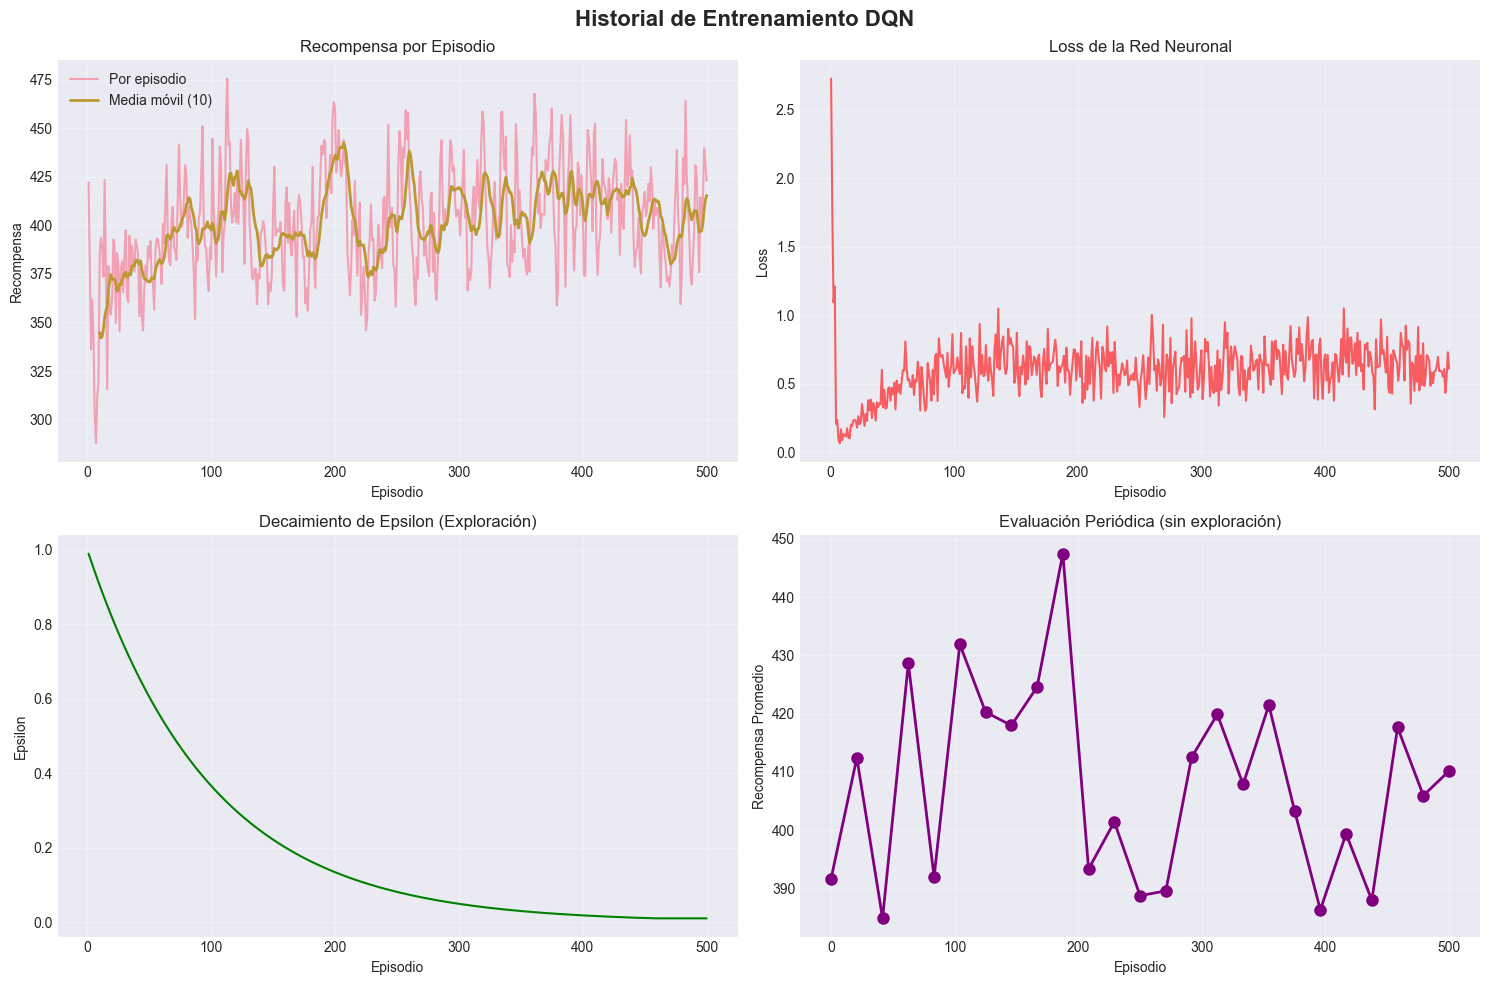

In [16]:
def plot_training_history(history):
    """Visualiza el historial de entrenamiento"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Historial de Entrenamiento DQN', fontsize=16, fontweight='bold')

    # Recompensa por episodio
    ax = axes[0, 0]
    episodes = range(1, len(history['episode_rewards']) + 1)
    ax.plot(episodes, history['episode_rewards'], alpha=0.6, label='Por episodio')

    # Moving average
    window = 10
    if len(history['episode_rewards']) >= window:
        moving_avg = pd.Series(history['episode_rewards']).rolling(window=window).mean()
        ax.plot(episodes, moving_avg, linewidth=2, label=f'Media móvil ({window})')

    ax.set_xlabel('Episodio')
    ax.set_ylabel('Recompensa')
    ax.set_title('Recompensa por Episodio')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Loss
    ax = axes[0, 1]
    ax.plot(episodes, history['episode_losses'], color='red', alpha=0.6)
    ax.set_xlabel('Episodio')
    ax.set_ylabel('Loss')
    ax.set_title('Loss de la Red Neuronal')
    ax.grid(True, alpha=0.3)

    # Epsilon decay
    ax = axes[1, 0]
    ax.plot(episodes, history['epsilon_values'], color='green')
    ax.set_xlabel('Episodio')
    ax.set_ylabel('Epsilon')
    ax.set_title('Decaimiento de Epsilon (Exploración)')
    ax.grid(True, alpha=0.3)

    # Evaluación periódica
    ax = axes[1, 1]
    if history['eval_rewards']:
        eval_episodes = np.linspace(0, len(episodes), len(history['eval_rewards']))
        ax.plot(eval_episodes, history['eval_rewards'], marker='o',
                linewidth=2, markersize=8, color='purple')
        ax.set_xlabel('Episodio')
        ax.set_ylabel('Recompensa Promedio')
        ax.set_title('Evaluación Periódica (sin exploración)')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualizar
plot_training_history(training_history)


## 6. Evaluación y Comparación con Baselines <a name="evaluacion"></a>

### 6.1 Implementación de Estrategias Baseline

Compararemos nuestro agente DQN contra 4 estrategias baseline:
1. **Static Baseline**: Configuración manual fija
2. **Random Baseline**: Selección aleatoria de acciones
3. **Greedy Baseline**: Selección greedy de mejor acción inmediata
4. **Q-Learning Tabular**: Q-Learning simple con tabla Q

In [17]:
class StaticBaseline:
    """Configuración estática manual"""

    def __init__(self, num_aps):
        self.num_aps = num_aps
        # Configuración fija: canales 1, 6, 11 alternados
        self.channels = [1, 6, 11]

    def select_action(self, state):
        """No cambia configuración - siempre retorna acción 'no cambio'"""
        # Acción que mantiene configuración actual
        return 0  # Primera acción disponible

    def reset(self):
        pass


class RandomBaseline:
    """Selección aleatoria de acciones"""

    def __init__(self, action_dim):
        self.action_dim = action_dim

    def select_action(self, state):
        """Selecciona acción aleatoria"""
        return np.random.randint(0, self.action_dim)

    def reset(self):
        pass


class GreedyBaseline:
    """Selección greedy basada en métrica inmediata"""

    def __init__(self, env):
        self.env = env
        self.last_metrics = None

    def select_action(self, state):
        """Selecciona acción que maximiza throughput inmediato"""
        # Obtener métricas actuales
        current_metrics = self.env.get_metrics()

        if self.last_metrics is None:
            # Primera vez, seleccionar acción aleatoria
            self.last_metrics = current_metrics
            return np.random.randint(0, self.env.action_dim)

        # Buscar AP con menor throughput
        throughputs = current_metrics['throughput']
        worst_ap = np.argmin(throughputs)

        # Generar acción para mejorar ese AP
        # Cambiar a canal con menos interferencia (simplificado)
        channel_action = worst_ap * self.env.actions_per_ap + np.random.randint(0, 3)

        self.last_metrics = current_metrics
        return channel_action

    def reset(self):
        self.last_metrics = None


class QLearningBaseline:
    """Q-Learning tabular simple"""

    def __init__(self, state_dim, action_dim, n_bins=5):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n_bins = n_bins

        # Tabla Q (diccionario para estados discretos)
        self.Q = defaultdict(lambda: np.zeros(action_dim))

        # Hiperparámetros
        self.alpha = 0.1  # learning rate
        self.gamma = 0.95  # discount factor
        self.epsilon = 0.1  # exploration rate (fijo)

    def discretize_state(self, state):
        """Discretiza estado continuo"""
        # Normalizar y discretizar
        state_normalized = np.clip(state, 0, 1)
        state_discrete = np.floor(state_normalized * self.n_bins).astype(int)
        state_discrete = np.clip(state_discrete, 0, self.n_bins - 1)
        return tuple(state_discrete)

    def select_action(self, state):
        """Selección epsilon-greedy"""
        discrete_state = self.discretize_state(state)

        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.action_dim)
        else:
            return int(np.argmax(self.Q[discrete_state]))

    def update(self, state, action, reward, next_state, done):
        """Actualiza tabla Q"""
        s = self.discretize_state(state)
        s_next = self.discretize_state(next_state)

        # Q-learning update
        best_next_action = np.argmax(self.Q[s_next])
        td_target = reward + (1 - done) * self.gamma * self.Q[s_next][best_next_action]
        td_error = td_target - self.Q[s][action]
        self.Q[s][action] += self.alpha * td_error

    def reset(self):
        pass


# Test de baselines
print("=== Test de Baselines ===\\n")

test_static = StaticBaseline(num_aps=4)
print(f"Static Baseline action: {test_static.select_action(state)}")

test_random = RandomBaseline(action_dim=test_env.action_dim)
print(f"Random Baseline action: {test_random.select_action(state)}")

test_greedy = GreedyBaseline(env=test_env)
print(f"Greedy Baseline action: {test_greedy.select_action(state)}")

test_qlearning = QLearningBaseline(state_dim=test_env.state_dim,
                                   action_dim=test_env.action_dim)
print(f"Q-Learning Baseline action: {test_qlearning.select_action(state)}")

=== Test de Baselines ===\n
Static Baseline action: 0
Random Baseline action: 35
Greedy Baseline action: 11
Q-Learning Baseline action: 0


### 6.2 Función de Evaluación Comparativa


In [18]:
def evaluate_baseline(env, baseline, num_episodes=50, baseline_name="Baseline"):
    """Evalúa una estrategia baseline"""

    episode_rewards = []
    episode_metrics = defaultdict(list)

    for episode in tqdm(range(num_episodes), desc=f"Evaluating {baseline_name}"):
        state = env.reset()
        baseline.reset()

        episode_reward = 0.0
        episode_throughputs = []
        episode_latencies = []
        episode_packet_losses = []

        step_count = 0
        while step_count < env.max_steps:
            # Seleccionar acción
            action = baseline.select_action(state)

            # Ejecutar
            next_state, reward, done, info = env.step(action)

            # Si es Q-Learning, actualizar
            if isinstance(baseline, QLearningBaseline):
                baseline.update(state, action, reward, next_state, done)

            # Recolectar métricas
            metrics = info['metrics']
            episode_throughputs.append(np.mean(metrics['throughput']))
            episode_latencies.append(np.mean(metrics['latency']))
            episode_packet_losses.append(np.mean(metrics['packet_loss_rate']))

            episode_reward += reward
            state = next_state
            step_count += 1

            if done:
                break

        episode_rewards.append(episode_reward)
        episode_metrics['throughput'].append(np.mean(episode_throughputs))
        episode_metrics['latency'].append(np.mean(episode_latencies))
        episode_metrics['packet_loss'].append(np.mean(episode_packet_losses))

    results = {
        'rewards': episode_rewards,
        'avg_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'metrics': episode_metrics
    }

    return results


def evaluate_dqn_agent(env, agent, num_episodes=50):
    """Evalúa agente DQN entrenado"""

    episode_rewards = []
    episode_metrics = defaultdict(list)

    for episode in tqdm(range(num_episodes), desc="Evaluating DQN Agent"):
        state = env.reset()
        episode_reward = 0.0
        episode_throughputs = []
        episode_latencies = []
        episode_packet_losses = []

        step_count = 0
        while step_count < env.max_steps:
            # Sin exploración
            action = agent.select_action(state, training=False)

            next_state, reward, done, info = env.step(action)

            # Recolectar métricas
            metrics = info['metrics']
            episode_throughputs.append(np.mean(metrics['throughput']))
            episode_latencies.append(np.mean(metrics['latency']))
            episode_packet_losses.append(np.mean(metrics['packet_loss_rate']))

            episode_reward += reward
            state = next_state
            step_count += 1

            if done:
                break

        episode_rewards.append(episode_reward)
        episode_metrics['throughput'].append(np.mean(episode_throughputs))
        episode_metrics['latency'].append(np.mean(episode_latencies))
        episode_metrics['packet_loss'].append(np.mean(episode_packet_losses))

    results = {
        'rewards': episode_rewards,
        'avg_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'metrics': episode_metrics
    }

    return results

In [19]:
# EVALUACIÓN COMPLETA 
print("\\n=== Evaluación Comparativa ===\\n")

NUM_EVAL_EPISODES = 50

# Crear entorno de evaluación (nuevo seed)
eval_env = WiFiEnvironment(SCENARIOS['medium_congestion'])
eval_env.set_reward_function(reward_function)

# Evaluar DQN
print("\\n1. Evaluando DQN Agent...")
dqn_results = evaluate_dqn_agent(eval_env, train_agent, NUM_EVAL_EPISODES)

# Evaluar Static Baseline
print("\\n2. Evaluando Static Baseline...")
static_baseline = StaticBaseline(num_aps=eval_env.num_aps)
static_results = evaluate_baseline(eval_env, static_baseline, NUM_EVAL_EPISODES, "Static")

# Evaluar Random Baseline
print("\\n3. Evaluando Random Baseline...")
random_baseline = RandomBaseline(action_dim=eval_env.action_dim)
random_results = evaluate_baseline(eval_env, random_baseline, NUM_EVAL_EPISODES, "Random")

# Evaluar Greedy Baseline
print("\\n4. Evaluando Greedy Baseline...")
greedy_baseline = GreedyBaseline(env=eval_env)
greedy_results = evaluate_baseline(eval_env, greedy_baseline, NUM_EVAL_EPISODES, "Greedy")

# Evaluar Q-Learning Baseline
print("\\n5. Evaluando Q-Learning Baseline...")
qlearning_baseline = QLearningBaseline(state_dim=eval_env.state_dim,
                                       action_dim=eval_env.action_dim)
qlearning_results = evaluate_baseline(eval_env, qlearning_baseline, NUM_EVAL_EPISODES, "Q-Learning")

print("\\n=== Evaluación Completada ===\\n")

# Resultados resumidos
results_summary = {
    'DQN': dqn_results,
    'Static': static_results,
    'Random': random_results,
    'Greedy': greedy_results,
    'Q-Learning': qlearning_results
}

# Tabla de resultados
results_df = pd.DataFrame({
    'Método': results_summary.keys(),
    'Recompensa Media': [r['avg_reward'] for r in results_summary.values()],
    'Desv. Estándar': [r['std_reward'] for r in results_summary.values()],
    'Throughput Medio': [np.mean(r['metrics']['throughput']) for r in results_summary.values()],
    'Latencia Media': [np.mean(r['metrics']['latency']) for r in results_summary.values()],
    'Pérdida Paquetes': [np.mean(r['metrics']['packet_loss']) for r in results_summary.values()]
})

print("\\n=== Tabla de Resultados ===\\n")
print(results_df.to_string(index=False))

\n=== Evaluación Comparativa ===\n
\n1. Evaluando DQN Agent...


Evaluating DQN Agent: 100%|█████████████████████| 50/50 [00:59<00:00,  1.19s/it]


\n2. Evaluando Static Baseline...


Evaluating Static: 100%|████████████████████████| 50/50 [00:20<00:00,  2.48it/s]


\n3. Evaluando Random Baseline...


Evaluating Random: 100%|████████████████████████| 50/50 [00:20<00:00,  2.49it/s]


\n4. Evaluando Greedy Baseline...


Evaluating Greedy: 100%|████████████████████████| 50/50 [00:20<00:00,  2.46it/s]


\n5. Evaluando Q-Learning Baseline...


Evaluating Q-Learning: 100%|████████████████████| 50/50 [00:21<00:00,  2.37it/s]

\n=== Evaluación Completada ===\n
\n=== Tabla de Resultados ===\n
    Método  Recompensa Media  Desv. Estándar  Throughput Medio  Latencia Media  Pérdida Paquetes
       DQN        426.898073       24.695045         30.585401       41.213551          0.003377
    Static        432.901846       24.258510         31.242655       41.181947          0.003463
    Random        344.367562       23.691492         25.029181       61.475674          0.007706
    Greedy        429.243540       22.945683         30.875940       41.890318          0.003484
Q-Learning        396.132782       22.411387         27.913414       47.809798          0.004668


## 7. Análisis de Resultados <a name="analisis"></a>

### 7.1 Visualizaciones Comparativas

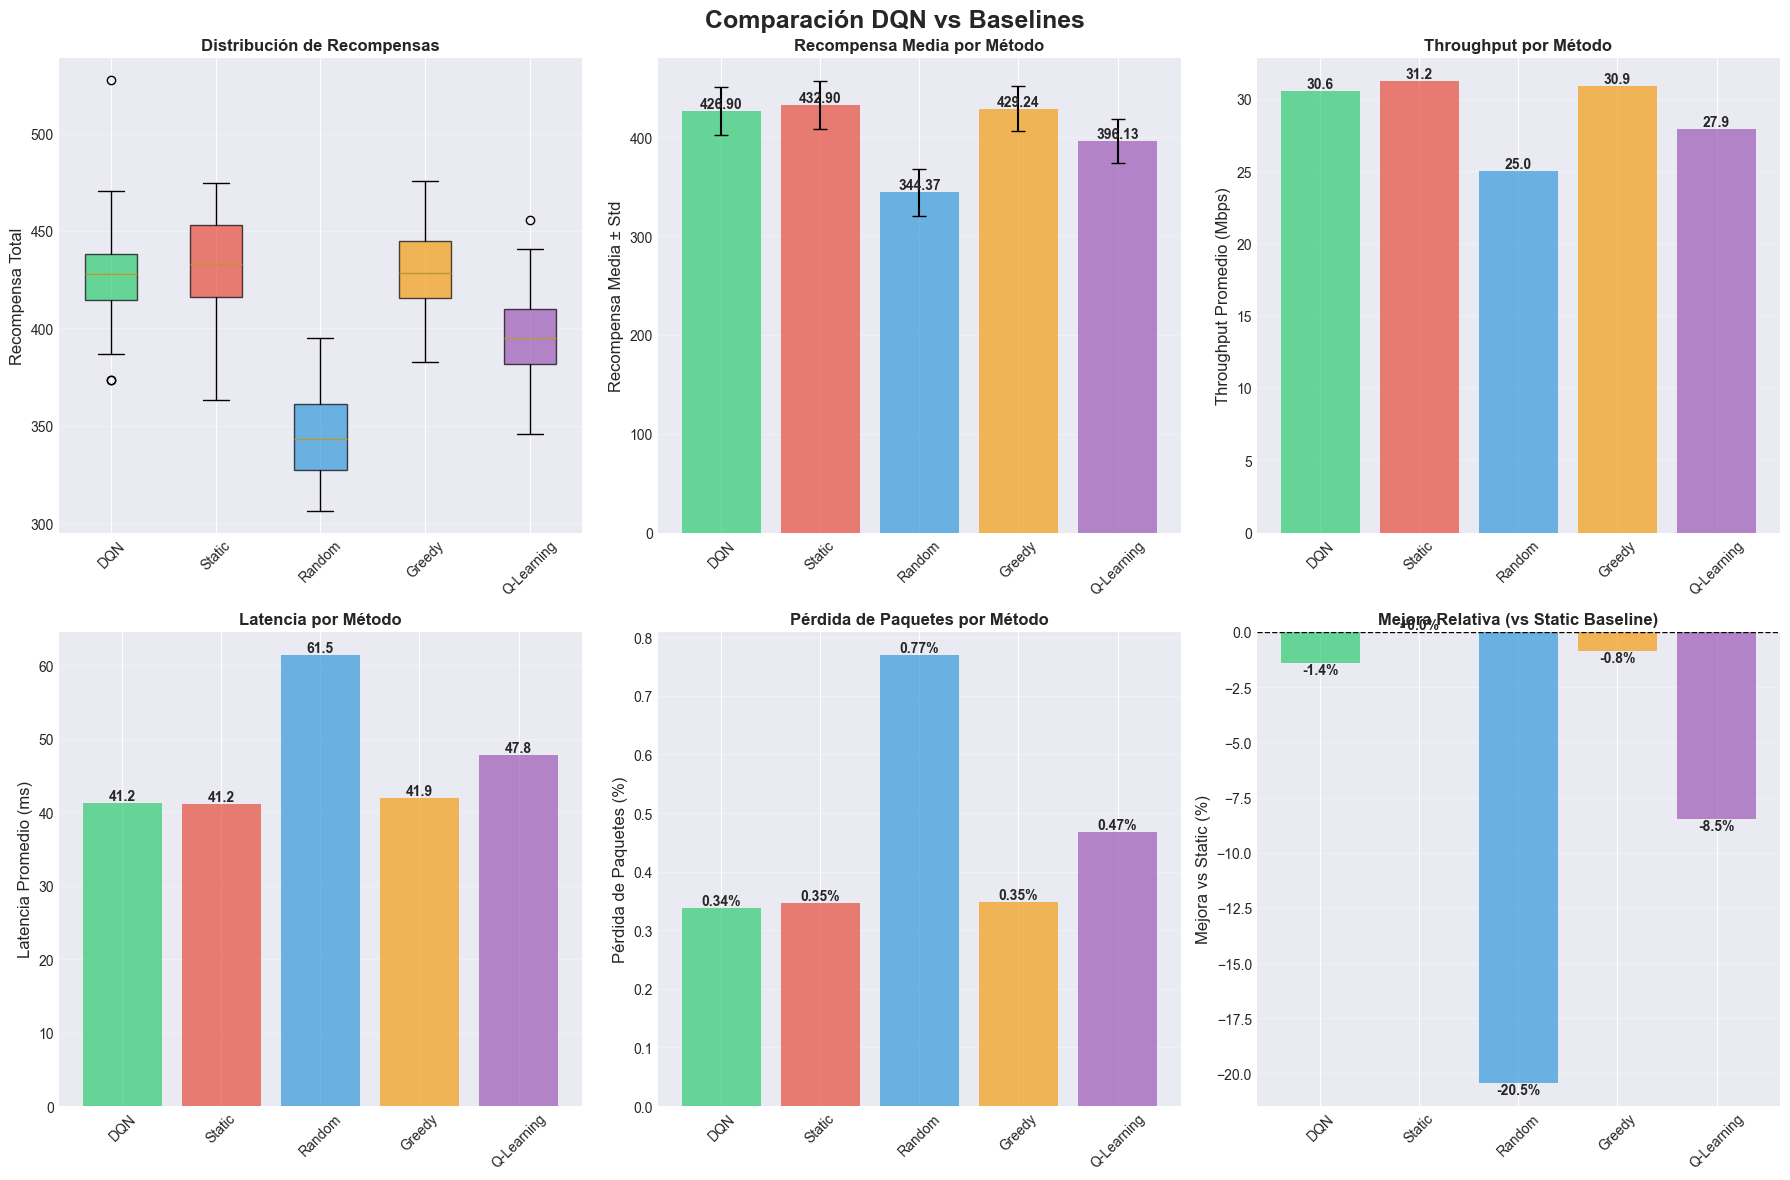

In [20]:
def plot_comparison_results(results_summary):
    """Visualiza comparación entre todos los métodos"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comparación DQN vs Baselines', fontsize=18, fontweight='bold')

    methods = list(results_summary.keys())
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6']

    # 1. Box plot de recompensas
    ax = axes[0, 0]
    reward_data = [results_summary[m]['rewards'] for m in methods]
    bp = ax.boxplot(reward_data, labels=methods, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_ylabel('Recompensa Total', fontsize=12)
    ax.set_title('Distribución de Recompensas', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)

    # 2. Gráfica de barras - Recompensa promedio
    ax = axes[0, 1]
    avg_rewards = [results_summary[m]['avg_reward'] for m in methods]
    std_rewards = [results_summary[m]['std_reward'] for m in methods]
    bars = ax.bar(methods, avg_rewards, yerr=std_rewards, capsize=5,
                   color=colors, alpha=0.7)
    ax.set_ylabel('Recompensa Media ± Std', fontsize=12)
    ax.set_title('Recompensa Media por Método', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)

    # Añadir valores en las barras
    for bar, val in zip(bars, avg_rewards):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

    # 3. Throughput promedio
    ax = axes[0, 2]
    throughputs = [np.mean(results_summary[m]['metrics']['throughput']) for m in methods]
    bars = ax.bar(methods, throughputs, color=colors, alpha=0.7)
    ax.set_ylabel('Throughput Promedio (Mbps)', fontsize=12)
    ax.set_title('Throughput por Método', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)

    for bar, val in zip(bars, throughputs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

    # 4. Latencia promedio
    ax = axes[1, 0]
    latencies = [np.mean(results_summary[m]['metrics']['latency']) for m in methods]
    bars = ax.bar(methods, latencies, color=colors, alpha=0.7)
    ax.set_ylabel('Latencia Promedio (ms)', fontsize=12)
    ax.set_title('Latencia por Método', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)

    for bar, val in zip(bars, latencies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

    # 5. Pérdida de paquetes
    ax = axes[1, 1]
    packet_losses = [np.mean(results_summary[m]['metrics']['packet_loss']) * 100
                     for m in methods]
    bars = ax.bar(methods, packet_losses, color=colors, alpha=0.7)
    ax.set_ylabel('Pérdida de Paquetes (%)', fontsize=12)
    ax.set_title('Pérdida de Paquetes por Método', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)

    for bar, val in zip(bars, packet_losses):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}%', ha='center', va='bottom', fontweight='bold')

    # 6. Mejora relativa vs Static
    ax = axes[1, 2]
    static_reward = results_summary['Static']['avg_reward']
    improvements = [(results_summary[m]['avg_reward'] - static_reward) / abs(static_reward) * 100
                    for m in methods]
    bars = ax.bar(methods, improvements, color=colors, alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.set_ylabel('Mejora vs Static (%)', fontsize=12)
    ax.set_title('Mejora Relativa (vs Static Baseline)', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)

    for bar, val in zip(bars, improvements):
        height = bar.get_height()
        va = 'bottom' if val >= 0 else 'top'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:+.1f}%', ha='center', va=va, fontweight='bold')

    plt.tight_layout()
    plt.show()


# Visualizar comparación
plot_comparison_results(results_summary)

### 7.2 Análisis Estadístico

In [21]:
from scipy import stats

def perform_statistical_tests(results_summary):
    """Realiza tests estadísticos de comparación"""

    print("=== Análisis Estadístico ===\\n")

    # Obtener recompensas de DQN y cada baseline
    dqn_rewards = np.array(results_summary['DQN']['rewards'])

    print("1. T-Tests: DQN vs Baselines")
    print("-" * 60)

    for method in results_summary.keys():
        if method == 'DQN':
            continue

        baseline_rewards = np.array(results_summary[method]['rewards'])

        # T-test de dos muestras
        t_stat, p_value = stats.ttest_ind(dqn_rewards, baseline_rewards)

        # Calcular tamaño del efecto (Cohen's d)
        mean_diff = np.mean(dqn_rewards) - np.mean(baseline_rewards)
        pooled_std = np.sqrt((np.std(dqn_rewards)**2 + np.std(baseline_rewards)**2) / 2)
        cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0

        print(f"\\nDQN vs {method}:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.6f}")
        print(f"  Cohen's d: {cohens_d:.4f}")

        if p_value < 0.001:
            significance = "*** (p < 0.001)"
        elif p_value < 0.01:
            significance = "** (p < 0.01)"
        elif p_value < 0.05:
            significance = "* (p < 0.05)"
        else:
            significance = "n.s. (no significativo)"

        print(f"  Significancia: {significance}")

        if mean_diff > 0:
            print(f"  → DQN es MEJOR que {method}")
        else:
            print(f"  → {method} es MEJOR que DQN")

    # ANOVA para comparar todos los métodos
    print("\\n" + "=" * 60)
    print("\\n2. ANOVA: Comparación de todos los métodos")
    print("-" * 60)

    all_rewards = [results_summary[m]['rewards'] for m in results_summary.keys()]
    f_stat, p_value = stats.f_oneway(*all_rewards)

    print(f"\\nF-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.6f}")

    if p_value < 0.05:
        print("\\n→ Existen diferencias SIGNIFICATIVAS entre los métodos")
    else:
        print("\\n→ NO existen diferencias significativas entre los métodos")

    # Resumen de métricas
    print("\\n" + "=" * 60)
    print("\\n3. Resumen de Métricas")
    print("-" * 60)

    summary_data = []
    for method in results_summary.keys():
        summary_data.append({
            'Método': method,
            'Recompensa': f"{results_summary[method]['avg_reward']:.2f} ± {results_summary[method]['std_reward']:.2f}",
            'Throughput': f"{np.mean(results_summary[method]['metrics']['throughput']):.1f} Mbps",
            'Latencia': f"{np.mean(results_summary[method]['metrics']['latency']):.1f} ms",
            'Pérdida (%)': f"{np.mean(results_summary[method]['metrics']['packet_loss']) * 100:.2f}"
        })

    summary_df = pd.DataFrame(summary_data)
    print("\\n" + summary_df.to_string(index=False))


# Realizar análisis estadístico
perform_statistical_tests(results_summary)

=== Análisis Estadístico ===\n
1. T-Tests: DQN vs Baselines
------------------------------------------------------------
\nDQN vs Static:
  t-statistic: -1.2140
  p-value: 0.227647
  Cohen's d: -0.2453
  Significancia: n.s. (no significativo)
  → Static es MEJOR que DQN
\nDQN vs Random:
  t-statistic: 16.8814
  p-value: 0.000000
  Cohen's d: 3.4106
  Significancia: *** (p < 0.001)
  → DQN es MEJOR que Random
\nDQN vs Greedy:
  t-statistic: -0.4870
  p-value: 0.627312
  Cohen's d: -0.0984
  Significancia: n.s. (no significativo)
  → Greedy es MEJOR que DQN
\nDQN vs Q-Learning:
  t-statistic: 6.4578
  p-value: 0.000000
  Cohen's d: 1.3047
  Significancia: *** (p < 0.001)
  → DQN es MEJOR que Q-Learning
\n============================================================
\n2. ANOVA: Comparación de todos los métodos
------------------------------------------------------------
\nF-statistic: 122.9353
p-value: 0.000000
\n→ Existen diferencias SIGNIFICATIVAS entre los métodos
\n====================

### 7.3 Visualización de Evolución Temporal

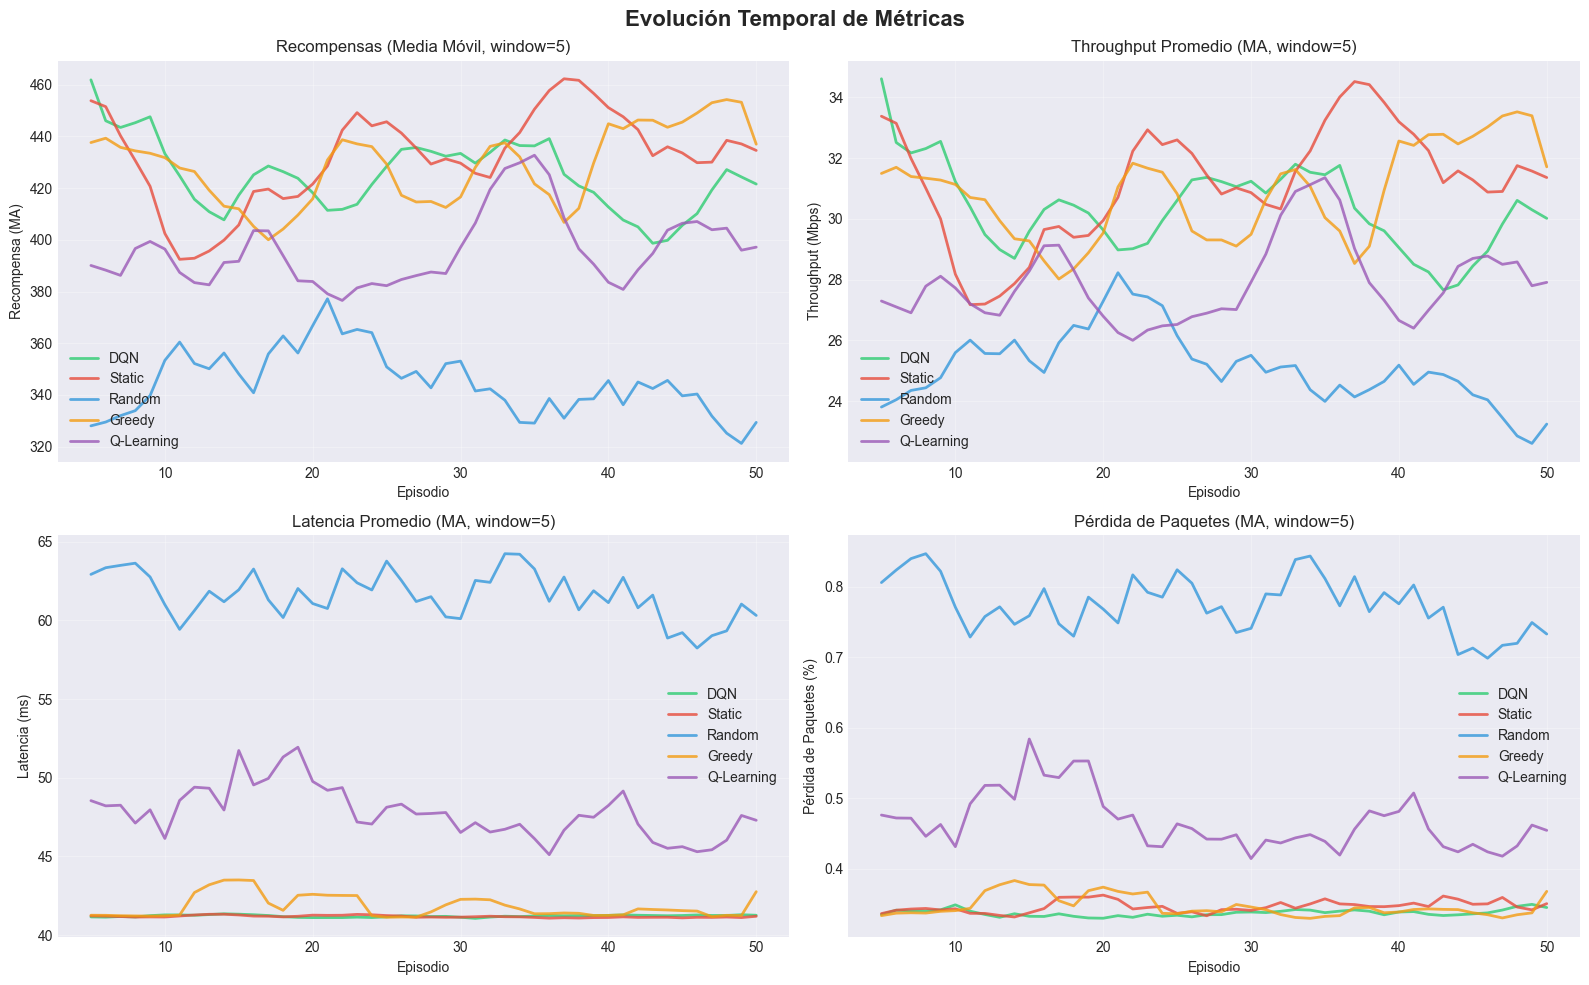

In [22]:
def plot_temporal_evolution(results_summary, window=5):
    """Visualiza evolución temporal de métricas"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Evolución Temporal de Métricas', fontsize=16, fontweight='bold')

    methods = list(results_summary.keys())
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6']

    # 1. Recompensas por episodio
    ax = axes[0, 0]
    for method, color in zip(methods, colors):
        rewards = results_summary[method]['rewards']
        episodes = range(1, len(rewards) + 1)

        # Moving average
        if len(rewards) >= window:
            ma_rewards = pd.Series(rewards).rolling(window=window).mean()
            ax.plot(episodes, ma_rewards, linewidth=2, label=method,
                   color=color, alpha=0.8)

    ax.set_xlabel('Episodio')
    ax.set_ylabel('Recompensa (MA)')
    ax.set_title(f'Recompensas (Media Móvil, window={window})')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Throughput por episodio
    ax = axes[0, 1]
    for method, color in zip(methods, colors):
        throughputs = results_summary[method]['metrics']['throughput']
        episodes = range(1, len(throughputs) + 1)

        if len(throughputs) >= window:
            ma_thr = pd.Series(throughputs).rolling(window=window).mean()
            ax.plot(episodes, ma_thr, linewidth=2, label=method,
                   color=color, alpha=0.8)

    ax.set_xlabel('Episodio')
    ax.set_ylabel('Throughput (Mbps)')
    ax.set_title(f'Throughput Promedio (MA, window={window})')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Latencia por episodio
    ax = axes[1, 0]
    for method, color in zip(methods, colors):
        latencies = results_summary[method]['metrics']['latency']
        episodes = range(1, len(latencies) + 1)

        if len(latencies) >= window:
            ma_lat = pd.Series(latencies).rolling(window=window).mean()
            ax.plot(episodes, ma_lat, linewidth=2, label=method,
                   color=color, alpha=0.8)

    ax.set_xlabel('Episodio')
    ax.set_ylabel('Latencia (ms)')
    ax.set_title(f'Latencia Promedio (MA, window={window})')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Pérdida de paquetes por episodio
    ax = axes[1, 1]
    for method, color in zip(methods, colors):
        packet_losses = [x * 100 for x in results_summary[method]['metrics']['packet_loss']]
        episodes = range(1, len(packet_losses) + 1)

        if len(packet_losses) >= window:
            ma_loss = pd.Series(packet_losses).rolling(window=window).mean()
            ax.plot(episodes, ma_loss, linewidth=2, label=method,
                   color=color, alpha=0.8)

    ax.set_xlabel('Episodio')
    ax.set_ylabel('Pérdida de Paquetes (%)')
    ax.set_title(f'Pérdida de Paquetes (MA, window={window})')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Visualizar evolución temporal
plot_temporal_evolution(results_summary)

### 8 SIMULACIÓN DINÁMICA ###


=== INICIANDO PRUEBA DE ESTRÉS (DQN) ===


Stress Test: 100%|██████| 100/100 [00:26<00:00,  3.77it/s, Users=50, Lat=43.7ms]


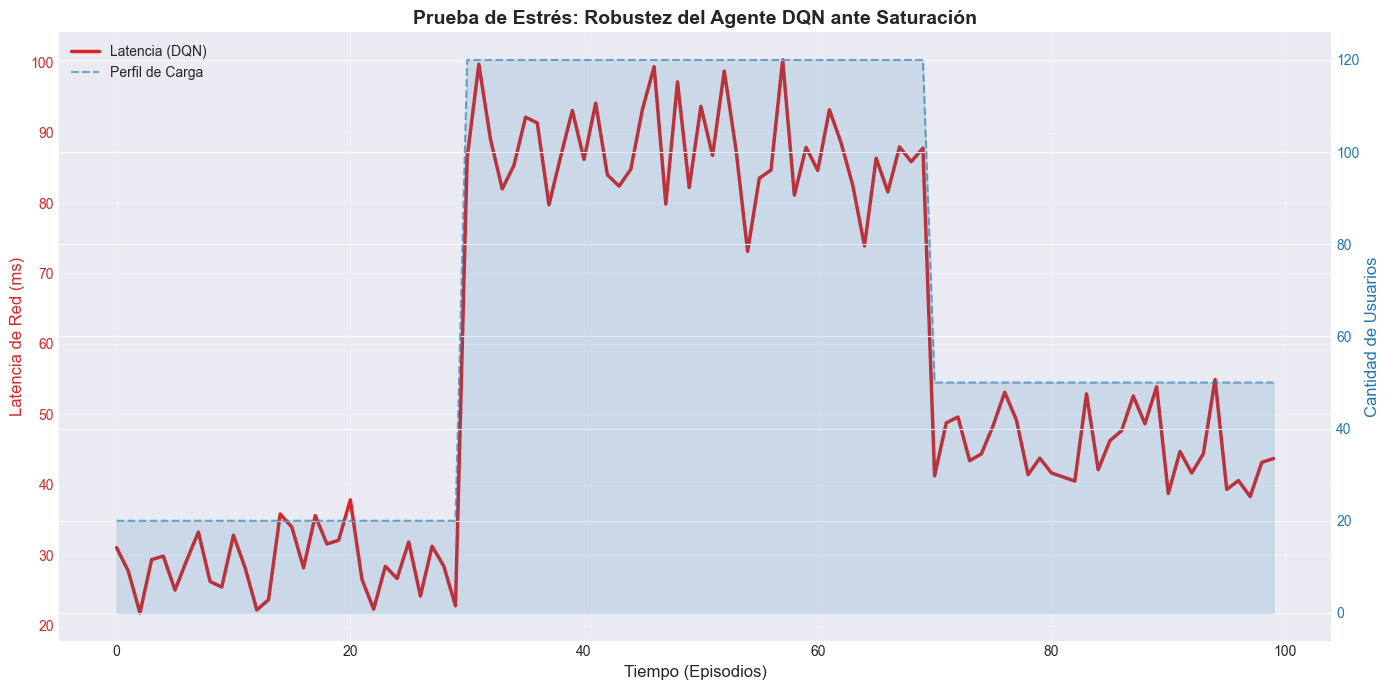


Resumen de Latencia:
Carga Baja  (20 usrs): 28.8 ms
Carga Alta (120 usrs): 87.5 ms
Recuperación (50 usrs): 45.4 ms


In [25]:
# ---  PRUEBA DE ESTRÉS (DQN) ---

def run_dqn_stress_test(agent, base_env):
 
    print("\n=== INICIANDO PRUEBA DE ESTRÉS (DQN) ===")
    
    # 1. Definir el perfil de carga (Simulando un día en la oficina)
    # 30 eps tranquilos -> 40 eps de saturación -> 30 eps normales
    load_profile = [20] * 30 + [120] * 40 + [50] * 30
    
    history = {
        "users": [],
        "latency": [],
        "throughput": [],
        "packet_loss": []
    }
    
    # Usamos el mismo entorno pero modificaremos sus internos
    env = base_env
    
    # Barra de progreso
    pbar = tqdm(range(len(load_profile)), desc='Stress Test')
    
    for i in pbar:
        num_users_target = load_profile[i]
        
        # --- DINAMISMO MODIFICANDO CANTIDAD DE USUARIOS ---
        # Vaciamos y rellenamos la lista de usuarios del simulador
        env.simulator.users = [] 
        area_x, area_y = env.config['area_size']
        
        for u_id in range(num_users_target):
            # Crear usuario en posición aleatoria
            x = np.random.uniform(0, area_x)
            y = np.random.uniform(0, area_y)
            # Demanda de tráfico variable
            traffic = np.random.uniform(1.0, 8.0) 
            env.simulator.add_user((x, y), traffic)
            
    
        env.config['num_users'] = num_users_target
        
        # --- EJECUTAR EPISODIO ---
        state = env.reset()
        ep_latency = []
        ep_throughput = []
        ep_loss = []
        
        step_count = 0
        while step_count < 50: 
            # Acción sin exploración 
            action = agent.select_action(state, training=False)
            
            next_state, _, done, info = env.step(action)
            state = next_state
            
            # Guardar métricas
            m = info['metrics']
            ep_latency.append(np.mean(m['latency']))
            ep_throughput.append(np.mean(m['throughput']))
            ep_loss.append(np.mean(m['packet_loss_rate']))
            
            step_count += 1
            if done: break
            
        # Guardar promedios del episodio
        history["users"].append(num_users_target)
        history["latency"].append(np.mean(ep_latency))
        history["throughput"].append(np.mean(ep_throughput))
        history["packet_loss"].append(np.mean(ep_loss))
        
        pbar.set_postfix({'Users': num_users_target, 'Lat': f'{history["latency"][-1]:.1f}ms'})

    return history


stress_data = run_dqn_stress_test(train_agent, train_env)

plt.figure(figsize=(14, 7))

# Configurar eje primario (Latencia)
ax1 = plt.gca()
ax1.set_xlabel('Tiempo (Episodios)', fontsize=12)
ax1.set_ylabel('Latencia de Red (ms)', color='tab:red', fontsize=12)
l1 = ax1.plot(stress_data["latency"], color='tab:red', linewidth=2.5, label='Latencia (DQN)')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, alpha=0.3)

# Configurar eje secundario (Carga de Usuarios)
ax2 = ax1.twinx()
ax2.set_ylabel('Cantidad de Usuarios', color='tab:blue', fontsize=12)

# Dibujar área de carga
x = range(len(stress_data["users"]))
y = stress_data["users"]
ax2.fill_between(x, y, color='tab:blue', alpha=0.15, label='Carga de Usuarios')
l2 = ax2.plot(x, y, color='tab:blue', linestyle='--', alpha=0.6, label='Perfil de Carga')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Títulos y Leyenda
plt.title('Prueba de Estrés: Robustez del Agente DQN ante Saturación', fontsize=14, fontweight='bold')

# Unir leyendas de ambos ejes
lns = l1 + l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

plt.tight_layout()
plt.show()

# resumen numérico
print(f"\nResumen de Latencia:")
print(f"Carga Baja  (20 usrs): {np.mean(stress_data['latency'][:30]):.1f} ms")
print(f"Carga Alta (120 usrs): {np.mean(stress_data['latency'][30:70]):.1f} ms")
print(f"Recuperación (50 usrs): {np.mean(stress_data['latency'][70:]):.1f} ms")